# 学習済みの畳み込みベースを用いたCNNの例題
# Dog or Cat判別
認識率を上げるため、既に学習されているモデルを利用する方法がある。

CNNの場合は、畳み込み層の内容を他の学習モデル同等にし、全結合層のみ1から学習させることが多い。

理由としては畳み込み層は汎用的で判別する対象が異なる場合でも利用できる場合が多いため。

全結合層はそれぞれの判別器に特化しているため再利用できる機会は少ない。

In [1]:
%matplotlib inline

import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.applications import VGG16

np.random.seed(20210101)
tf.random.set_seed(20210101)

print("tensorflow version : " + tf.__version__)

tensorflow version : 2.3.1


# Get the trained model VGG16

In [2]:
conv_base = VGG16(weights='imagenet',
                  #畳み込みベースの層のみ利用し、全結合層は利用しない
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Create the learning model using VGG16 conv layer

In [3]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


# Freeze the conv model parameters

In [4]:
#訓練を行う前にconv modelの凍結を行い、VGG16用に学習されたパラメータから変更しないようにする
#凍結しない場合、下の学習処理でconv部分のパラメータも変更されてしまうため
conv_base.trainable = False

# Modify the input data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '.\\datasets\\cnn_dog_vs_cat'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#学習データが少ないため、回転・平行移動・拡大等でデータ拡張(水増し)を行う
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

#検証データは水増しを行うべきではない
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
50/50 [==============================] - 11s 222ms/step - loss: 0.5972 - accuracy: 0.6740 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 2/50
50/50 [==============================] - 11s 222ms/step - loss: 0.4573 - accuracy: 0.7760 - val_loss: 0.3658 - val_accuracy: 0.8330
Epoch 3/50
50/50 [==============================] - 11s 222ms/step - loss: 0.4526 - accuracy: 0.7680 - val_loss: 0.2862 - val_accuracy: 0.8870
Epoch 4/50
50/50 [==============================] - 12s 235ms/step - loss: 0.4162 - accuracy: 0.8090 - val_loss: 0.3567 - val_accuracy: 0.8370
Epoch 5/50
50/50 [==============================] - 12s 239ms/step - loss: 0.3710 - accuracy: 0.8350 - val_loss: 0.2891 - val_accuracy: 0.8830
Epoch 6/50
50/50 [==============================] - 12s 239ms/step - loss: 0.3717 - accuracy: 0.8430 - val_loss: 0.2589 - val_accuracy: 0.8980
Epoch 7/50
50/50 [==============================] - 11s 223ms/step

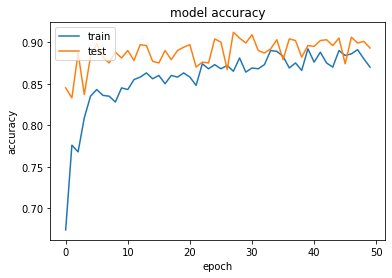

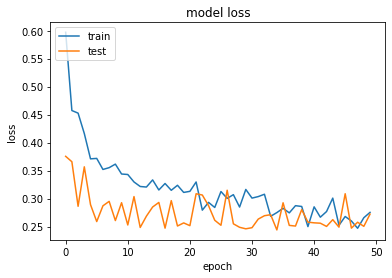

In [6]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

training = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=50,
      validation_data=validation_generator)

#正答率
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model

In [7]:
model.save('models\\cnn_dog_vs_cat_using_vgg16_conv.h5')
#model.save('models/cnn_dog_vs_cat_using_vgg16_conv.h5')

print(model.input)
print(model.output)

Tensor("vgg16_input:0", shape=(None, 150, 150, 3), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)


# Fine turning
畳み込み層の後段のいくつかを解凍し、新たに追加した部分(全結合層)と共に学習を行う。

畳み込み層の入力側の層はより汎用的で再利用可能な特徴量を処理しており、
後段の層はより非汎用的であるため。

今回はblock5の内容をFine turninする。

Fine turningを行う際には下記の手順で行う。

1.訓練済みのモデルの最後に独自のモデルを追加する

2.訓練済みのモデルを凍結する

3.訓練を行う

4.訓練済みのモデルの一部の層を解凍する

5.解凍した層と独自のモデルの学習を再度行う

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
# block5のみ解凍を行う
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Epoch 1/50
50/50 [==============================] - 12s 235ms/step - loss: 0.2810 - accuracy: 0.8690 - val_loss: 0.2400 - val_accuracy: 0.9060
Epoch 2/50
50/50 [==============================] - 12s 233ms/step - loss: 0.2521 - accuracy: 0.8940 - val_loss: 0.2445 - val_accuracy: 0.9100
Epoch 3/50
50/50 [==============================] - 12s 240ms/step - loss: 0.2193 - accuracy: 0.9150 - val_loss: 0.2513 - val_accuracy: 0.9140
Epoch 4/50
50/50 [==============================] - 12s 243ms/step - loss: 0.2250 - accuracy: 0.9090 - val_loss: 0.2354 - val_accuracy: 0.9210
Epoch 5/50
50/50 [==============================] - 12s 230ms/step - loss: 0.2024 - accuracy: 0.9200 - val_loss: 0.2334 - val_accuracy: 0.9090
Epoch 6/50
50/50 [==============================] - 11s 226ms/step - loss: 0.2178 - accuracy: 0.9140 - val_loss: 0.2208 - val_accuracy: 0.9190
Epoch 7/50
50/50 [==============================] - 11s 223ms/step - loss: 0.2160 - accuracy: 0.9080 - val_loss: 0.2243 - val_accuracy: 0.9150

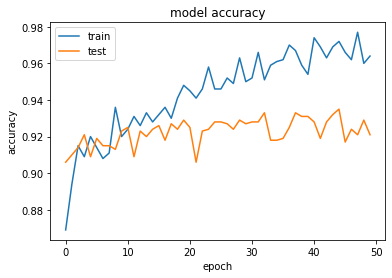

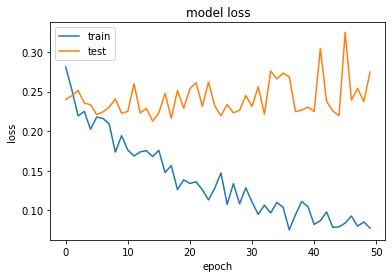

In [10]:
#Fine turning時はRMSpropと低い学習率を用いることが多い
#理由としては学習による変化量を制限したいため、変化量が大きいとパラメータが破壊されてしまうから
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

training = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=50,
      validation_data=validation_generator)

#正答率
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save('models\\cnn_dog_vs_cat_using_vgg16_conv2.h5')
#model.save('models/cnn_dog_vs_cat_using_vgg16_conv2.h5')

print(model.input)
print(model.output)

Tensor("vgg16_input:0", shape=(None, 150, 150, 3), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)


In [16]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.evaluate(test_generator, steps=50)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 67ms/step - loss: 0.3102 - accuracy: 0.9190


[0.31020474433898926, 0.9190000295639038]